In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import numpy as np
import rasterio as rio
from rasterstats import zonal_stats
from glob import glob

from src.utils import *
from src.params import *
tqdm.pandas()

import numpy as np
from pysal.explore import esda
from pysal.lib import weights
np.random.seed(42)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Load Model

In [3]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v5.csv',
        cols=['ppt_2021', 'hydraulic_c','median_hse', 'dem'], is_balanced=True)

balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


In [4]:
rs = 100
tune = 100

In [ ]:
# Modeling (full)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    ppt_mu = pm.Normal('ppt_mu', mu=0, sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_mu = pm.Normal('hydr_mu', mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    dem_beta = pm.HalfNormal('dem_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    ppt = pm.Normal('ppt', mu=ppt_mu, sigma=ppt_sig, dims='basin')
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig, dims='basin')
    hse = pm.Normal('hse', mu=0, sigma=hse_sig, dims='basin')
    dem = pm.Exponential('dem', lam=dem_beta, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + ppt[basin] * ppt_d
                                    + hydr[basin] * hydr_d
                                    + hse[basin] * hse_d
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [ ]:
# Get all learned parameters
hier_post = trace.posterior.stack(chain_draw=("chain", "draw"))

learned_params = dict()
learned_params.update({
    'c': hier_post['c'].mean().item(),
    'ppt': hier_post['ppt'].mean().item(),
    'hydr': hier_post['hydr'].mean().item(),
    'hse': hier_post['hse'].mean().item(),
    'dem': hier_post['dem'].mean().item()
})

learned_params

{'c': 0.051920490950255804,
 'ppt': -0.07891725599782004,
 'hydr': 0.012598212867099648,
 'hse': -0.048361020648337784,
 'dem': 0.5648904425238036}

In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 69.650839099658 ± 0.012608636651945197%


# Inference

Helper functions and constants

In [45]:
# Non-randomized class balancing
# learned_params = {'c': 6.89667835344772,
#  'ppt': 0.15925588067118088,
#  'hydr': -0.05084010228148568,
#  'hse': -0.007153556957056333,
#  'dem': 2.782393162111132}

# Randomized class balancing
learned_params = {'c': 0.051920490950255804,
 'ppt': -0.07891725599782004,
 'hydr': 0.012598212867099648,
 'hse': -0.048361020648337784,
 'dem': 0.5648904425238036}

def get_inference_data(indep_srcs, state_id):
    state_id = str(state_id)

    # Get boundary
    bdry = gpd.read_file(indep_srcs['bdry'])
    state_bdry = bdry[bdry['STATEFP'] == state_id].reset_index(drop=True)
    outer_bdry = state_bdry.dissolve()
    del indep_srcs['bdry']

    # Get raster mean value for each county
    for indep_var in indep_srcs.keys():
        filename = indep_srcs[indep_var]
        with rio.open(filename) as src:
            affine = src.transform
            array = src.read(1)
            zones = pd.DataFrame(zonal_stats(state_bdry, array, affine=affine, stats='median'))
        
        var_name = f'{indep_var}_median'
        state_bdry[var_name] = zones['median']

    # Get housing value
    acs_dict = {
        'type': 'acs5',
        'year': 2019,
        'state': state_id,
        'code': 'B25077_001E',
        'col_name': 'median_hse'
    }

    acs = (censusdata.download(
        acs_dict['type'],
        acs_dict['year'], 
        censusdata.censusgeo([('state', acs_dict['state']), ('county', '*')]), [acs_dict['code']]
    ).reset_index().rename(columns={acs_dict['code']: 'median_hse'}))

    for i, row in acs.iterrows():
        county = (str(row['index'])
                    .split(',')[0]
                    .split('County')[0]
                    .strip())

        acs.loc[i, 'County'] = county
    
    for i, row in state_bdry.iterrows():
        try:
            hse_mean = acs[acs['County'] == row['NAME']]['median_hse'].item()
            state_bdry.loc[i, 'hse_median'] = hse_mean
        except:
            state_bdry.loc[i, 'hse_median'] = 0

    return state_bdry

# Compute probability of failure 
def compute_risk_probability(gdf, learned_params, sampling_sz=100, runs=5):
    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        failure_theta = pm.math.sigmoid(learned_params['c']
                                            + learned_params['ppt'] * row['ppt_median']
                                            + learned_params['hydr'] * row['soil_median']
                                            + learned_params['hse'] * row['hse_median']
                                            + learned_params['dem'] * row['dem_median']
                                        )
        risks = []
        failures = pm.Bernoulli.dist(failure_theta)
        for j in range(runs):
            risk = failures.random(size=sampling_sz)
            risks.append(risk.mean())
        
        risk_mean = np.array(risks).mean()
        risk_std = np.array(risks).std()
        gdf.loc[i, 'risk_mean'] = risk_mean
        gdf.loc[i, 'risk_std'] = risk_std

    # gdf['risk_mean'] = (gdf['risk_mean'] - gdf['risk_mean'].min()) / (gdf['risk_mean'].max() - gdf['risk_mean'].min())
    
    return gdf

## Nationwide

In [76]:
try:
    del all_gdf
except:
    pass

soil_files = glob('../../Data/soil/mosaic/*.tif')

for soil_file in soil_files:
    state_abbr = soil_file.split('/')[-1].split('.tif')[0]
    print(f'Processing {state_abbr}')
    state_id = state_codes[state_abbr]
    indep_srcs = {
        'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
        'ppt': '../../Data/precipitation/annual_max_2021.tif',
        'soil': soil_file,
        'dem': '../../Data/dem/hyd_na_dem_15s.tif',
    }
    gdf = get_inference_data(indep_srcs, state_id=state_id)
    try:
        all_gdf = all_gdf.append(gdf)
    except:
        all_gdf = gdf

all_gdf = all_gdf.reset_index(drop=True)
all_gdf = all_gdf.fillna(0.)
for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
    all_gdf[var] = (all_gdf[var] - all_gdf[var].mean()) / all_gdf[var].std() # z-normalize
    
all_gdf = compute_risk_probability(all_gdf, learned_params)

Processing SD
Processing GA
Processing IN
Processing IL
Processing KS
Processing SC
Processing NY
Processing MT
Processing OK
Processing NM
Processing MA
Processing OH
Processing WY
Processing MD
Processing MS
Processing NH
Processing CO
Processing LA
Processing ME
Processing UT
Processing WI
Processing AR
Processing NJ
Processing VA
Processing CA
Processing ND
Processing CT
Processing NE
Processing MI
Processing VT
Processing TX
Processing OR
Processing NV
Processing TN
Processing MN
Processing AZ
Processing AL
Processing MO
Processing NC
Processing WV
Processing WA
Processing IA
Processing RI
Processing PA
Processing FL
Processing DE
Processing KY
Processing DC
Processing ID


100%|██████████| 3108/3108 [11:31<00:00,  4.50it/s]


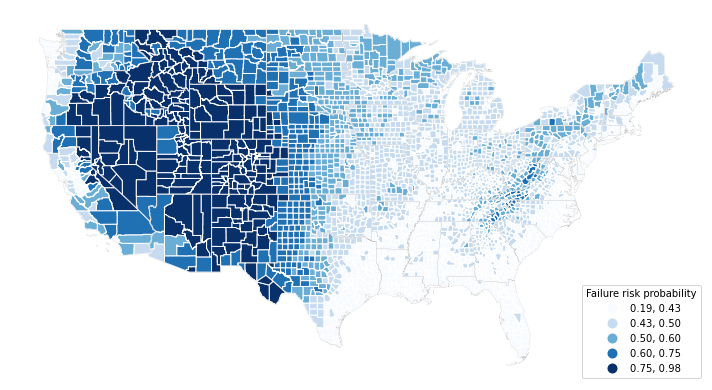

In [77]:
# Plot
f, ax = plt.subplots(figsize=(10,10))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

all_gdf.plot(
    column='risk_mean', 
    edgecolor='1.',
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability', 'loc': 'lower right'})

bdry[bdry['STATEFP'].isin(list(state_codes.values()))].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()
f.savefig('../docs/USA_risk_map.pdf', dpi=300, bbox_inches='tight')

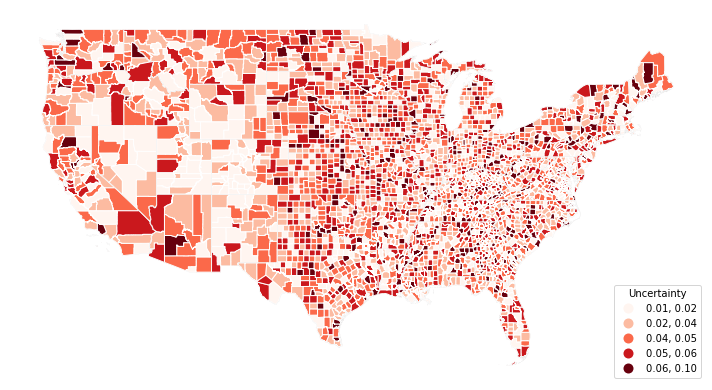

In [78]:
# Plot
f, ax = plt.subplots(figsize=(10,10))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

all_gdf.plot(
    column='risk_std', 
    edgecolor='1.',
    cmap='Reds', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Uncertainty', 'loc': 'lower right'})

bdry[bdry['STATEFP'].isin(list(state_codes.values()))].dissolve(by='STATEFP').boundary.plot(
    edgecolor='lightgrey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()
f.savefig('../docs/USA_risk_map_std.pdf', dpi=300, bbox_inches='tight')

## Southeast
Subset to GA, FL, AL, TN, SC, NC, KY, VA, WV, AR, LA, MS

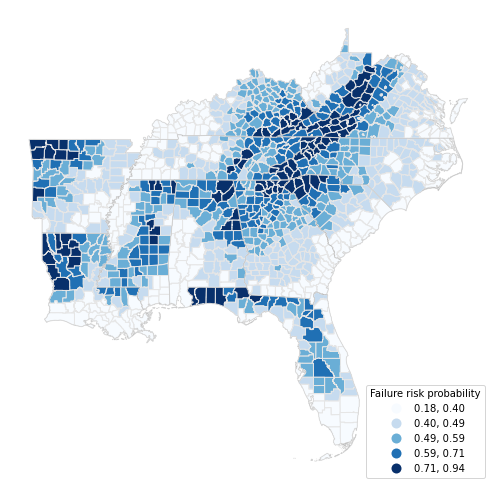

In [60]:
try:
    del all_gdf
except:
    pass

soil_files = glob('../../Data/soil/mosaic/*.tif')
southeast_states = ['GA', 'FL', 'AL', 'TN', 'SC', 'NC', 'KY', 'VA', 'WV', 'AR', 'LA', 'MS']
southeast_ids = [state_codes[state] for state in southeast_states]

for soil_file in soil_files:
    state_abbr = soil_file.split('/')[-1].split('.tif')[0]
    
    if state_abbr in southeast_states:
        print(f'Processing {state_abbr}')
        state_id = state_codes[state_abbr]
        indep_srcs = {
            'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
            'ppt': '../../Data/precipitation/annual_max_2021.tif',
            'soil': soil_file,
            'dem': '../../Data/dem/hyd_na_dem_15s.tif',
        }
        gdf = get_inference_data(indep_srcs, state_id=state_id)
        for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
            gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
        gdf.reset_index(drop=True, inplace=True)
        gdf.fillna(0., inplace=True)
        gdf = compute_risk_probability(gdf, learned_params)
        
        try:
            all_gdf = all_gdf.append(gdf)
        except:
            all_gdf = gdf

# Plot
f, ax = plt.subplots(figsize=(7,7))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

southeast_gdf = all_gdf[all_gdf['STATEFP'].isin(southeast_ids)]
southeast_gdf.plot(
    column='risk_mean', 
    edgecolor='0.9',
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability', 'loc': 'lower right'})

bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()
f.savefig('../docs/southeast_risk_map.pdf', dpi=300, bbox_inches='tight')

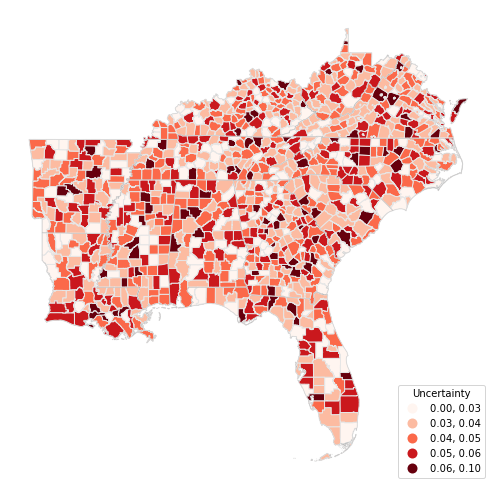

In [59]:
# Plot
f, ax = plt.subplots(figsize=(7,7))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

southeast_gdf = all_gdf[all_gdf['STATEFP'].isin(southeast_ids)]
southeast_gdf.plot(
    column='risk_std', 
    edgecolor='0.9',
    cmap='Reds', 
    scheme='natural_breaks',
    ax=ax,
    legend=True, legend_kwds={'title': 'Uncertainty', 'loc': 'lower right'})

bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()
f.savefig('../docs/southeast_risk_map_std.pdf', dpi=300, bbox_inches='tight')

## Cluster Analysis

In [61]:
def generate_local_cluster(cluster_df, var, p_val = 0.05):
    w = weights.Queen.from_dataframe(cluster_df)
    go_i_star = esda.getisord.G_Local(cluster_df[var] + abs(cluster_df[var].min()), w, transform='r', star=True) #value shifted to floor 0 stability
    cluster_df[f'{var}_cluster_z'] = go_i_star.Zs

    sig = go_i_star.p_sim < p_val

    return cluster_df, sig

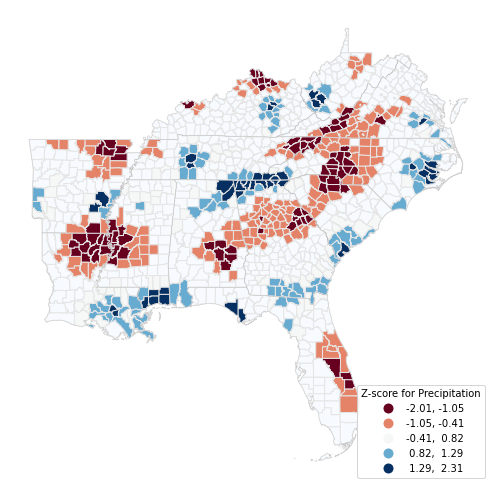

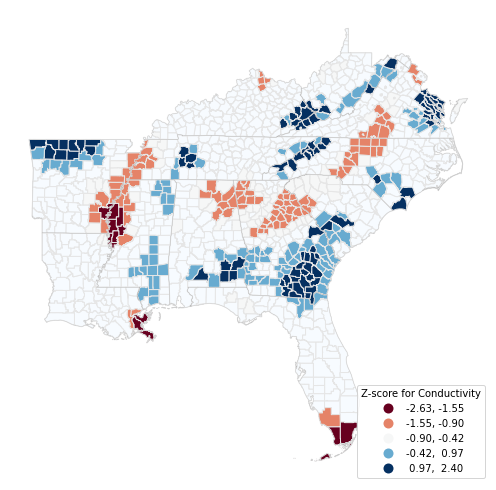

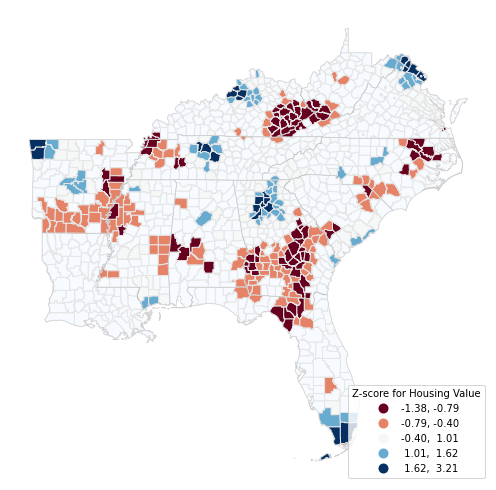

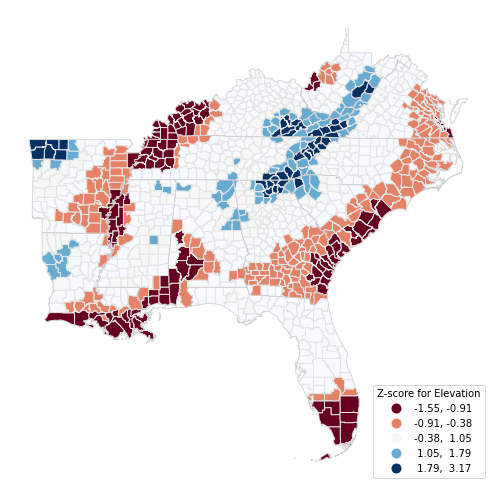

In [67]:
# All variables
southeast_gdf.reset_index(drop=True, inplace=True)
cluster_gdf = southeast_gdf

titles = ['Precipitation', 'Conductivity', 'Housing Value', 'Elevation']
for i, var in enumerate(['ppt_median', 'soil_median', 'hse_median', 'dem_median']):
    cluster_gdf, sig = generate_local_cluster(cluster_gdf, var=var)

    # Plotting
    f, ax = plt.subplots(figsize=(7,7))

    # Plot non-significant clusters
    ns = cluster_gdf.loc[sig == False, 'geometry']
    ns.plot(ax=ax, color='#f7fbff', edgecolor='0.9', linewidth=1)

    # Plot clusters
    cluster_gdf[sig].plot(
        column=f'{var}_cluster_z', 
        scheme='natural_breaks', 
        ax=ax, cmap='RdBu', 
        legend=True,
        edgecolor='0.9',
        legend_kwds={'title': f'Z-score for {titles[i]}', 'loc': 'lower right'}
    )
    bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
        edgecolor='grey',
        linewidth=0.1,
        ax=ax
    )

    ax.axis('off')
    f.tight_layout()
    f.savefig(f'../docs/cluster_{var}.pdf', dpi=300, bbox_inches='tight');

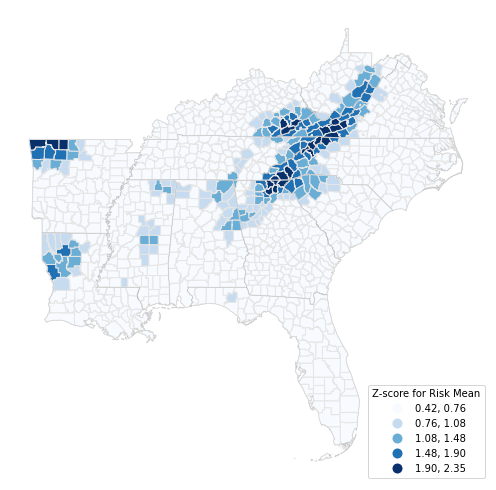

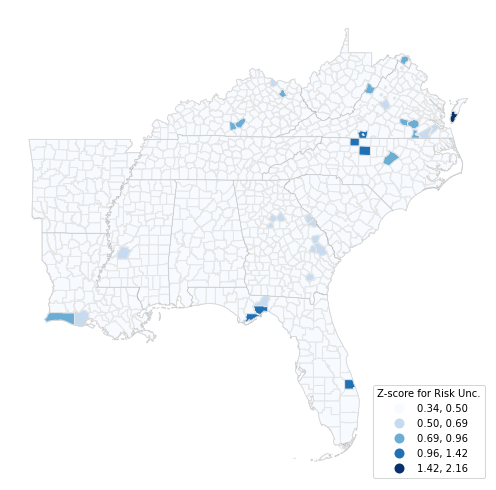

In [73]:
# Risk estimates
southeast_gdf.reset_index(drop=True, inplace=True)
cluster_gdf = southeast_gdf

titles = ['Risk Mean', 'Risk Unc.']
for i, var in enumerate(['risk_mean', 'risk_std']):
    cluster_gdf, sig = generate_local_cluster(cluster_gdf, var=var)
    

    # Plotting
    f, ax = plt.subplots(figsize=(7,7))

    # Plot non-significant clusters
    ns = cluster_gdf.loc[sig == False, 'geometry']
    ns.plot(ax=ax, color='#f7fbff', edgecolor='0.9', linewidth=1)

    # low cluster
    lc = cluster_gdf[cluster_gdf[f'{var}_cluster_z'] <= 0]['geometry']
    lc.plot(ax=ax, color='#f7fbff', edgecolor='0.9', linewidth=1)

    # Plot clusters
    cluster_gdf[sig][cluster_gdf[f'{var}_cluster_z'] > 0].plot(
        column=f'{var}_cluster_z', 
        scheme='natural_breaks', 
        ax=ax, cmap='Blues', 
        legend=True,
        edgecolor='0.9',
        legend_kwds={'title': f'Z-score for {titles[i]}', 'loc': 'lower right'}
    )
    bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
        edgecolor='grey',
        linewidth=0.1,
        ax=ax
    )

    ax.axis('off')
    f.tight_layout()
    f.savefig(f'../docs/cluster_{var}.pdf', dpi=300, bbox_inches='tight');

### Correlation with uncertainty

In [64]:
def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}\np-val = {p:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

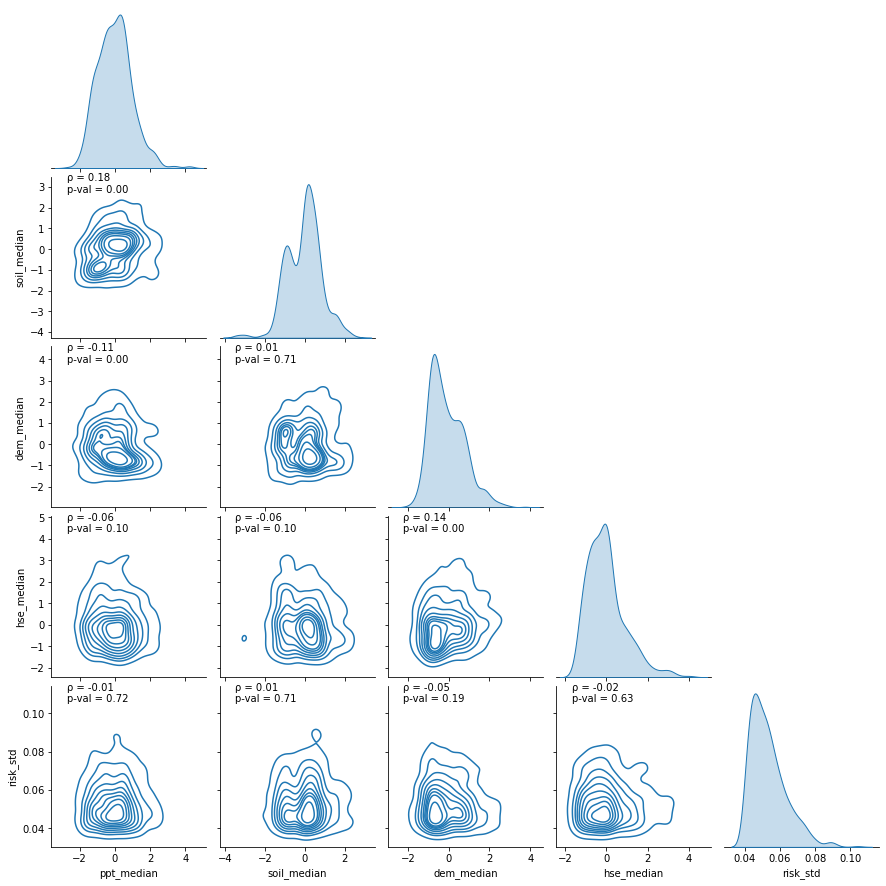

In [70]:
# Plot pairplot with norm_inputs
cluster_var = ['ppt_median', 'soil_median', 'dem_median', 'hse_median', 'risk_std']
# cluster_gdf['risk_std_norm'] = (cluster_gdf['risk_std'] - cluster_gdf['risk_std'].mean()) / cluster_gdf['risk_std'].std()
high_unc = cluster_gdf[cluster_gdf['risk_std'] >= cluster_gdf['risk_std'].mean()]
g = sns.pairplot(high_unc[cluster_var], kind='kde', corner=True)
g.map_lower(corrfunc)
g.savefig('../docs/pairplot_unc_indep.pdf', dpi=300, bbox_inches='tight')

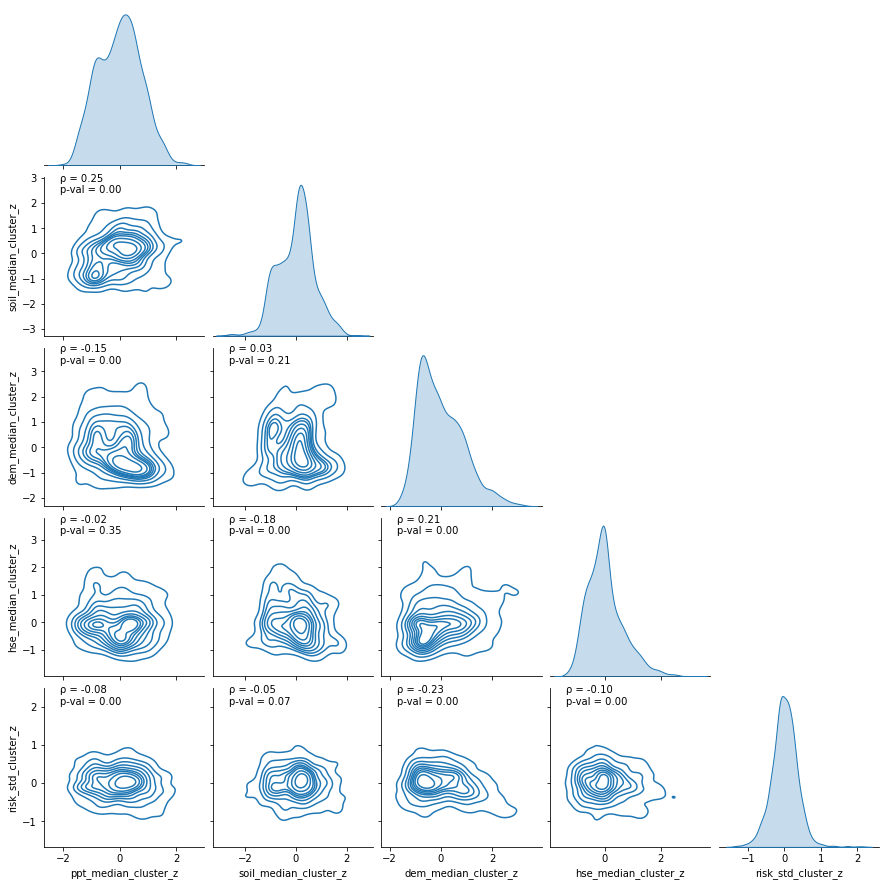

In [75]:
# Plot pairplot with cluster_z
cluster_var = ['ppt_median_cluster_z', 'soil_median_cluster_z', 'dem_median_cluster_z', 'hse_median_cluster_z', 'risk_std_cluster_z']
# cluster_gdf['risk_std_norm'] = (cluster_gdf['risk_std'] - cluster_gdf['risk_std'].mean()) / cluster_gdf['risk_std'].std()
g = sns.pairplot(cluster_gdf[cluster_var], kind='kde', corner=True)
g.map_lower(corrfunc)
g.savefig('../docs/pairplot_unc_cluster.pdf', dpi=300, bbox_inches='tight')

## Georgia

100%|██████████| 159/159 [00:01<00:00, 128.66it/s]


(-85.8434368, -80.60145719999998, 30.1257106, 35.2327994)

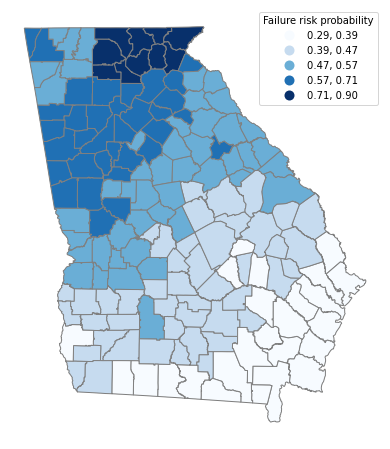

In [46]:
state_id = '13' # Georgia
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'dem': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = gdf.reset_index(drop=True)
gdf = gdf.fillna(0.)
for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability'})


bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
# f.savefig('../docs/GA_risk_map.pdf', dpi=300)

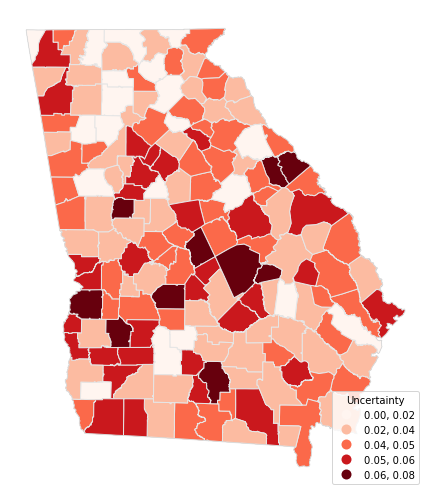

In [47]:
# Plot
f, ax = plt.subplots(figsize=(7,7))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

gdf.plot(
    column='risk_std', 
    edgecolor='0.9',
    cmap='Reds', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Uncertainty', 'loc': 'lower right'})

bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()

<AxesSubplot:>

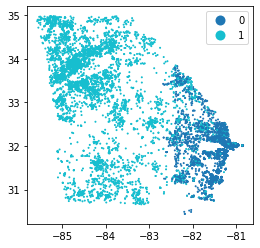

In [11]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['tblSGA_Property.gis_long_property'], df['tblSGA_Property.gis_lat_property']))
gdf.sample(n=12000).plot(column='sewageSystem_enc', categorical=True, legend=True, markersize=1)

## Florida

100%|██████████| 67/67 [00:00<00:00, 199.64it/s]


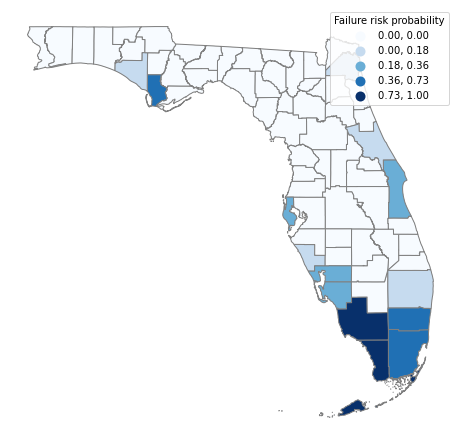

In [16]:
state_id = '12' # Florida
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/FL.tif',
    'dem': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = gdf.reset_index(drop=True)
gdf = gdf.fillna(0.)
for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability'})


bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.savefig('../docs/FL_risk_map.pdf', dpi=300)

## Alabama

100%|██████████| 67/67 [00:00<00:00, 200.28it/s]


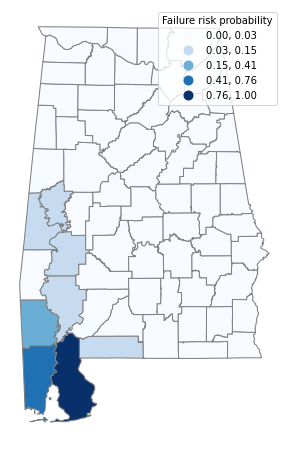

In [17]:
state_id = '01' # AL
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/AL.tif',
    'dem': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = gdf.reset_index(drop=True)
gdf = gdf.fillna(0.)
for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability'})


bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.savefig('../docs/AL_risk_map.pdf', dpi=300)

# Inspect Inputs

In [21]:
state_id = '13' # Georgia
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'dem': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)

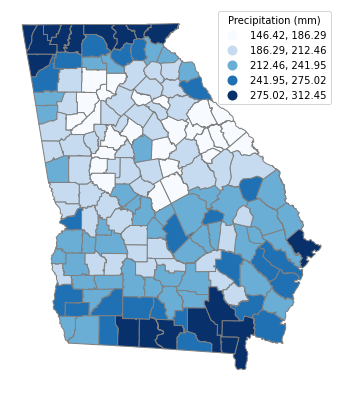

In [24]:
# Precipitation
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('ppt_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Precipitation (mm)'})

ax.axis('off');
f.savefig('../docs/GA_ppt.pdf', dpi=300, bbox_inches='tight')

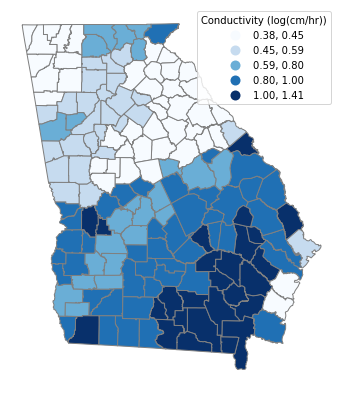

In [27]:
# Soil hydraulics
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('soil_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Conductivity (log(cm/hr))'})

ax.axis('off');
f.savefig('../docs/GA_soil.pdf', dpi=300, bbox_inches='tight')

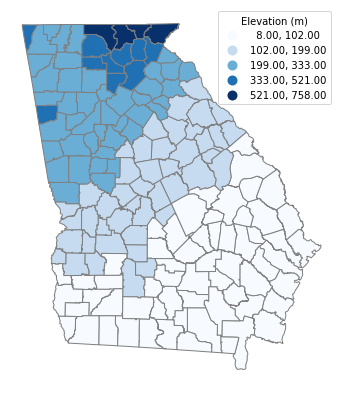

In [28]:
# DEM
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('dem_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Elevation (m)'})

ax.axis('off');
f.savefig('../docs/GA_dem.pdf', dpi=300, bbox_inches='tight')

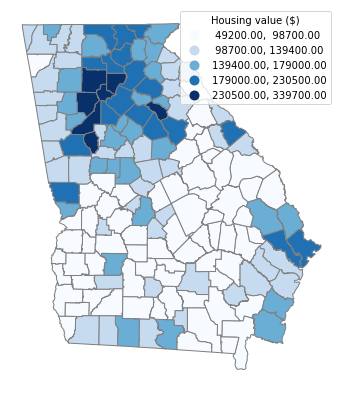

In [29]:
# Housing
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('hse_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Housing value ($)'})

ax.axis('off');
f.savefig('../docs/GA_hse.pdf', dpi=300, bbox_inches='tight')